In [1]:
%matplotlib inline
import pyspeckit
import numpy as np
from astropy import units as u
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.convolution import convolve, Box1DKernel
from c_normalize import c_normalize
import glob
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
plt.style.use('seaborn-paper')

In [2]:
from contextlib import contextmanager
import sys, os

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

# Python-based Automation of Equivalent Width Measurement
Utilizing pyspeckit (https://pyspeckit.readthedocs.io/en/latest/) and a python port of Joleen Carlberg's (STScI) Continuum Normalization algorithm, this notebook seeks to set up and test an automated equivalent width measurement algorithm for a number of spectrum for which we have hand measurements. The expectations for this method are that 95% of the measurements are within 5% of our by-hand measurements.

### An Example
Before diving straight into scripting, it's useful to layout an individual example of the equivalent width measurement process.

The fit may be poorly conditioned


EQW: 141.52166728162004 mA


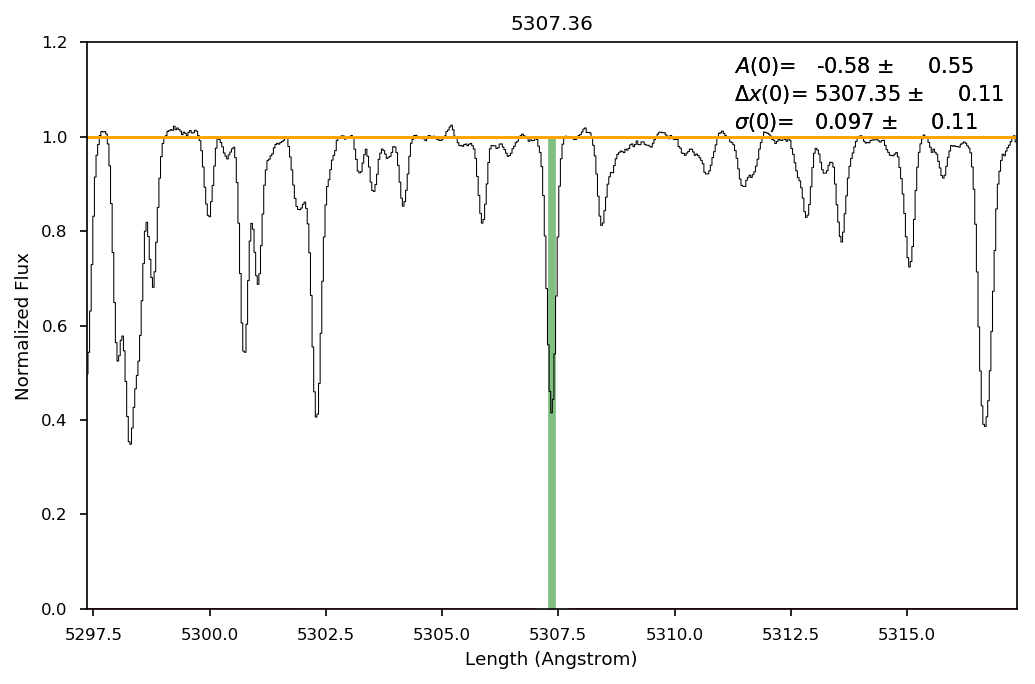

In [21]:
# Pull in an example spectrum
s_hdu = fits.open("Data/ew_known/tame_inputs/col110_1134red_oned_25jan14_wavsoln.fits")
fig = plt.figure(figsize=(8,5), dpi = 150)

# Grab the flux and wavelength arrays from the spectrum
s_data = s_hdu[1].data
s_flux = s_data['FLUX']
smoothed_flux = convolve(s_flux, Box1DKernel(5)) # Smooth the flux for more reliable continuum fitting
s_flux = smoothed_flux
s_wav = s_data['WAVEL']

# Specify up a specific line to measure the EQW for, and specify the wavelength range to sample for the local continuum
line_cen = 5307.36
width = 10
lim_l = line_cen - width
lim_r = line_cen + width

# Mask the flux and wavelength arrays based on the sampled wavelength range
wav_mask = (s_wav > lim_l) & (s_wav < lim_r)
s_flux = s_flux[wav_mask]
s_wav = s_wav[wav_mask]

# Normalize the spectrum with the local continuum to 1.0, c_normalize returns the normalized spectrum in norm, but also the local continuum fit in yfit if desired
yfit, norm, _ = c_normalize(s_flux, s_wav, median_replace=False, cheby=True, low_cut = 0.9)

# Load the normalized spectrum into a pyspeckit.Spectrum object
sp = pyspeckit.Spectrum(data=norm, xarr=s_wav * u.AA)
sp.plotter(figure = fig, xmin=lim_l, xmax=lim_r, ymin=0, ymax=1.2)

#Get around pyspeckits reliance on a generated baseline and just generate basespec as a ones array (continuum is always one in normalized case)
sp.baseline.basespec = np.ones(len(s_wav))

#Fit a gaussian to the line, this may be too simplistic for blended lines
sp.specfit(fittype='gaussian', guesses = [0.1, line_cen, 0.1])

#Measure the Equivalent Width of the gaussian line fit against the normalized baseline
EQW = sp.specfit.EQW(plot=True, continuum_as_baseline=True)
print("EQW:", EQW*1000*u.mA)
plt.axhline(1, color = 'orange')
plt.ylabel("Normalized Flux")
plt.title(str(line_cen))
#sp.plotter.savefig('basic_plot_example_withfit.png')

## Testing Consistency for a Line Across Multiple Spectrum
A crucial requirement for any automated equivalent width process is that it provides consistent results across the vast majority of spectrum for a given line.

In [4]:
# Select Datasets and extract equivalent widths
spectrum = glob.glob("data/ew_known/tame_inputs/*wavsoln.fits")
by_hand = glob.glob("tame-1.1.0/*.ew")
lc_range = np.arange(0.95,0.995,0.0001)
len_range = 10


d = {'Spectrum File': spectrum, 'By-Hand File': by_hand}
disp_df = pd.DataFrame(data=d)

data/ew_known/tame_inputs/ngc6583_39red_oned_slit07_jun14_wavsoln.fits 169.012775286 179.05
data/ew_known/tame_inputs/ngc6583_42red_oned_slit07_jun14_wavsoln.fits 174.534900173 190.3
data/ew_known/tame_inputs/ngc6583_62red_oned_slit07_jun14_wavsoln.fits 161.896486647 178.4
-0.832199465986 2.91175378527


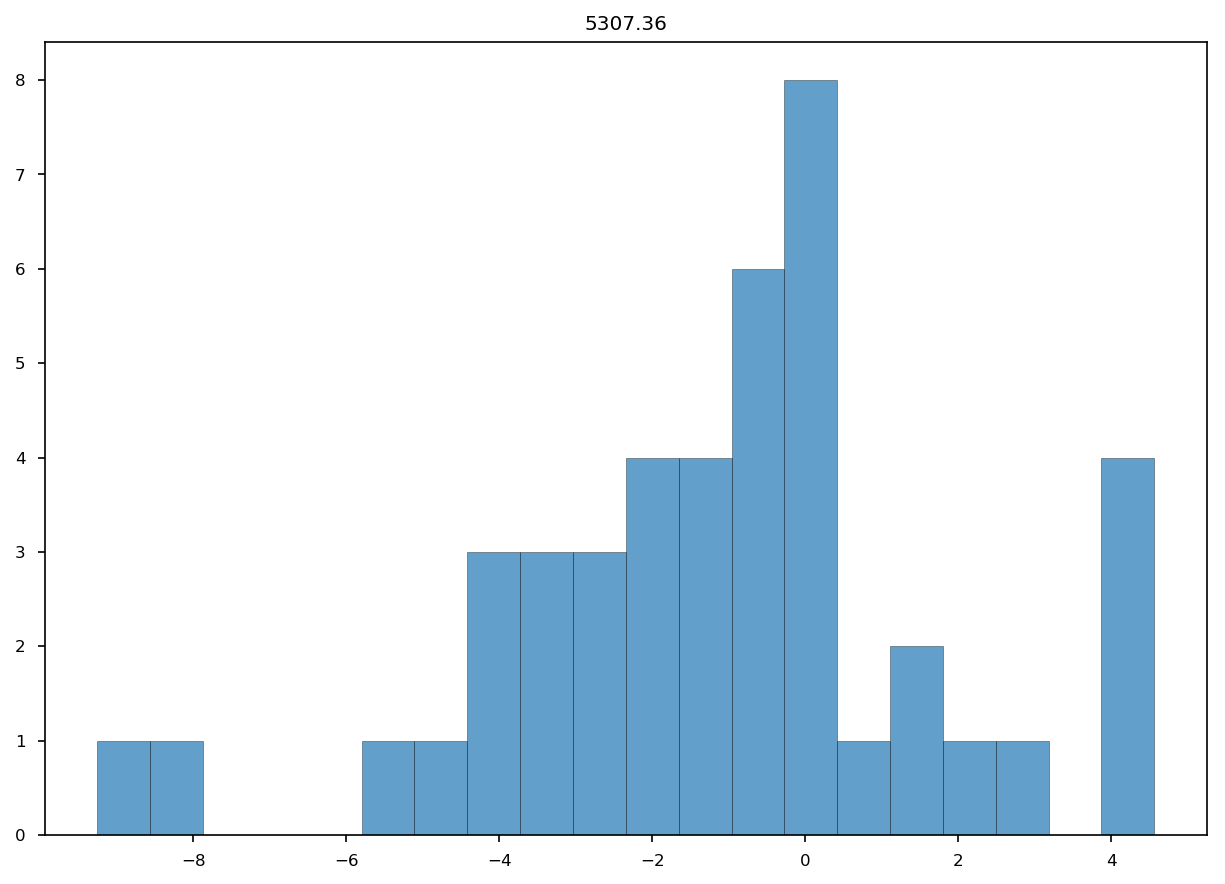

In [30]:
line = 5307.36
width = 10 #Distance from the line on both sides to sample the local continuum from
percent_difference = True

diff = []
for row in disp_df.iterrows():
    eqw_file, spec_file = row[1]
    eqw_df = pd.read_csv(eqw_file, header=None, delim_whitespace = True)
    if line not in eqw_df[0].tolist():
        print("Line Missing")
        continue
    mask = eqw_df[0] == line
    byhand_eqw = eqw_df[4][mask.tolist()].tolist()[0]
    if byhand_eqw == 0.:
        continue
    
    s_hdu = fits.open(spec_file)
    
    # Grab the flux and wavelength arrays from the spectrum
    s_data = s_hdu[1].data
    s_flux = s_data['FLUX']
    smoothed_flux = convolve(s_flux, Box1DKernel(5)) # Smooth the flux for more reliable continuum fitting
    s_flux = smoothed_flux
    s_wav = s_data['WAVEL']

    # Specify up a specific line to measure the EQW for, and specify the wavelength range to sample for the local continuum
    lim_l = line - width
    lim_r = line + width

    # Mask the flux and wavelength arrays based on the sampled wavelength range
    wav_mask = (s_wav > lim_l) & (s_wav < lim_r)
    s_flux = s_flux[wav_mask]
    s_wav = s_wav[wav_mask]

    # Normalize the spectrum with the local continuum to 1.0, c_normalize returns the normalized spectrum in norm, but also the local continuum fit in yfit if desired
    yfit, norm, _ = c_normalize(s_flux, s_wav, median_replace=False, cheby=True, low_cut = 0.92)
    # Load the normalized spectrum into a pyspeckit.Spectrum object
    sp = pyspeckit.Spectrum(data=norm, xarr=s_wav * u.AA)

    #Get around pyspeckits reliance on a generated baseline and just generate basespec as a ones array (continuum is always one in normalized case)
    sp.baseline.basespec = np.ones(len(s_wav))

    #Fit a gaussian to the line, this may be too simplistic for blended lines
    with suppress_stdout(): #Suppress some annoying info messages that don't translate well to automation
        sp.specfit(fittype='gaussian', guesses = [20, line, 0.1])

    #Measure the Equivalent Width of the gaussian line fit against the normalized baseline
    EQW = sp.specfit.EQW(plot=False, continuum_as_baseline=True, )
    EQW = EQW*1000 #mA
    #print("EQW:", EQW*1000*u.mA)
    #print(abs(EQW-byhand_eqw), byhand_eqw)
    if abs(EQW - byhand_eqw) > 10:
        print (spec_file, EQW, byhand_eqw)
    if percent_difference:
        diff.append(((EQW-byhand_eqw)/byhand_eqw) * 100) #Percent Difference
    else:
        diff.append(EQW-byhand_eqw) #mA Difference
fig = plt.figure(figsize=(10,7), dpi = 150)
plt.hist(diff,histtype='bar',ec='black',alpha=0.7,color = plt.cm.tab20(0),bins=20)
plt.title(line)
print(np.median(diff), np.std(diff))
    


data/ew_known/tame_inputs/ngc2204_3215red_oned_05jan14_wavsoln.fits 52.7821247052 62.9
data/ew_known/tame_inputs/ngc2204_4303red_oned_05jan14_wavsoln.fits 45.0284287562 56.0
data/ew_known/tame_inputs/ngc6583_38red_oned_slit07_jun14_wavsoln.fits 74.5559949295 89.4
-4.59891958275 6.16785404935


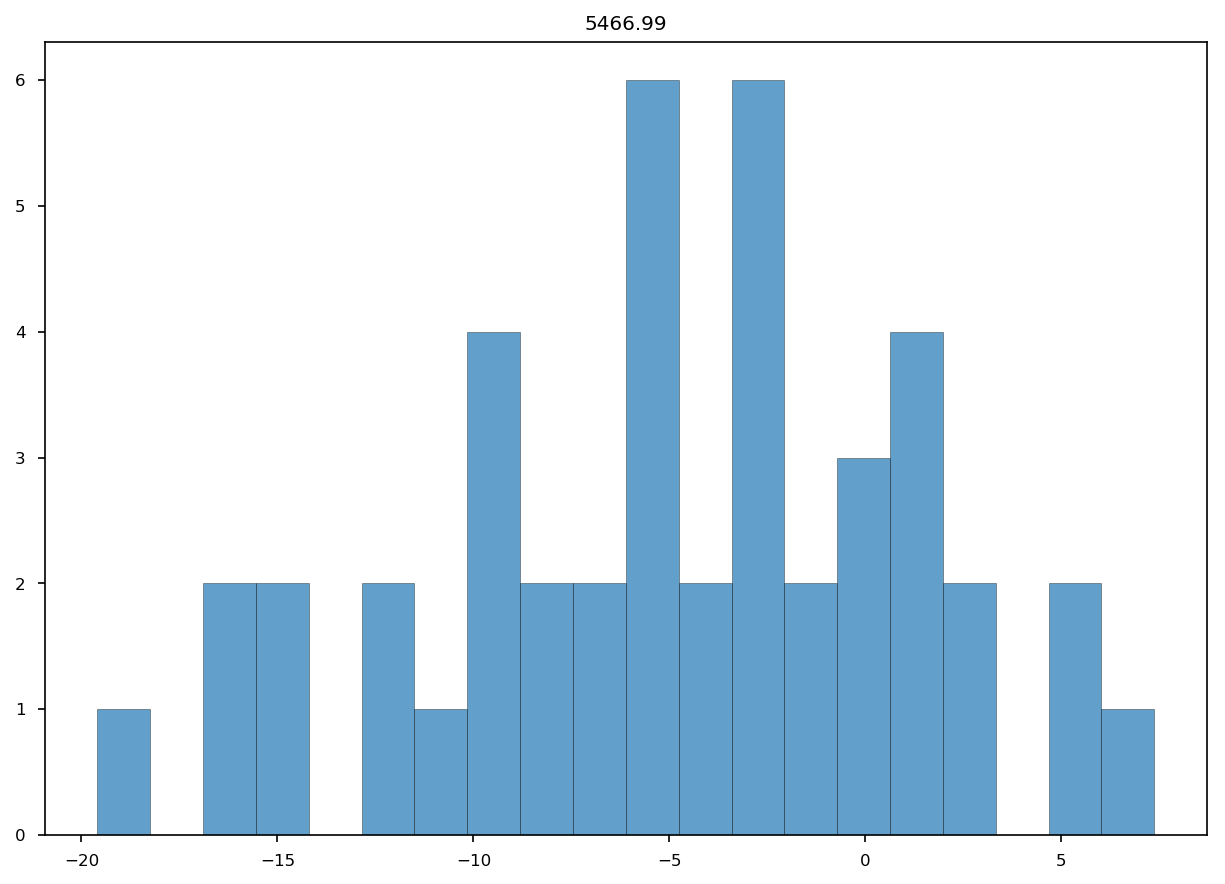

In [31]:
line = 5466.99 #5307.36
width = 10 #Distance from the line on both sides to sample the local continuum from
percent_difference = True

diff = []
for row in disp_df.iterrows():
    eqw_file, spec_file = row[1]
    eqw_df = pd.read_csv(eqw_file, header=None, delim_whitespace = True)
    if line not in eqw_df[0].tolist():
        print("Line Missing")
        continue
    mask = eqw_df[0] == line
    byhand_eqw = eqw_df[4][mask.tolist()].tolist()[0]
    if byhand_eqw == 0.:
        continue
    
    s_hdu = fits.open(spec_file)
    
    # Grab the flux and wavelength arrays from the spectrum
    s_data = s_hdu[1].data
    s_flux = s_data['FLUX']
    smoothed_flux = convolve(s_flux, Box1DKernel(5)) # Smooth the flux for more reliable continuum fitting
    s_flux = smoothed_flux
    s_wav = s_data['WAVEL']

    # Specify up a specific line to measure the EQW for, and specify the wavelength range to sample for the local continuum
    lim_l = line - width
    lim_r = line + width

    # Mask the flux and wavelength arrays based on the sampled wavelength range
    wav_mask = (s_wav > lim_l) & (s_wav < lim_r)
    s_flux = s_flux[wav_mask]
    s_wav = s_wav[wav_mask]

    # Normalize the spectrum with the local continuum to 1.0, c_normalize returns the normalized spectrum in norm, but also the local continuum fit in yfit if desired
    yfit, norm, _ = c_normalize(s_flux, s_wav, median_replace=False, cheby=True, low_cut = 0.7)
    # Load the normalized spectrum into a pyspeckit.Spectrum object
    sp = pyspeckit.Spectrum(data=norm, xarr=s_wav * u.AA)

    #Get around pyspeckits reliance on a generated baseline and just generate basespec as a ones array (continuum is always one in normalized case)
    sp.baseline.basespec = np.ones(len(s_wav))

    #Fit a gaussian to the line, this may be too simplistic for blended lines
    with suppress_stdout(): #Suppress some annoying info messages that don't translate well to automation
        sp.specfit(fittype='gaussian', guesses = [20, line, 0.1], exclude= [0,5466.5, 5467.5, 5500])

    #Measure the Equivalent Width of the gaussian line fit against the normalized baseline
    EQW = sp.specfit.EQW(plot=False, continuum_as_baseline=True, )
    EQW = EQW*1000 #mA
    #print("EQW:", EQW*1000*u.mA)
    #print(abs(EQW-byhand_eqw), byhand_eqw)
    if abs(EQW - byhand_eqw) > 10:
        print (spec_file, EQW, byhand_eqw)
    if percent_difference:
        diff.append(((EQW-byhand_eqw)/byhand_eqw) * 100) #Percent Difference
    else:
        diff.append(EQW-byhand_eqw) #mA Difference
fig = plt.figure(figsize=(10,7), dpi = 150)
plt.hist(diff,histtype='bar',ec='black',alpha=0.7,color = plt.cm.tab20(0),bins=20)
plt.title(line)
print(np.median(diff), np.std(diff))
    
